<p style="font-size:36px;text-align:center"> <b>Malaria Bounding Boxes</b> </p>

<h1>1. Business Problem</h1>

<h2>1.1. Description</h2>

<p> Data Source: https://www.kaggle.com/kmader/malaria-bounding-boxes </p>
<p> Data: malaria-bounding-boxes</p>

<h6> Problem statement : </h6>
<p>Malaria is a disease caused by Plasmodium parasites that remains a major threat in global health, affecting 200 million people and causing 400,000 deaths a year. The main species of malaria that affect humans are Plasmodium falciparum and Plasmodium vivax.

For malaria as well as other microbial infections, manual inspection of thick and thin blood smears by trained microscopists remains the gold standard for parasite detection and stage determination because of its low reagent and instrument cost and high flexibility. Despite manual inspection being extremely low throughput and susceptible to human bias, automatic counting software remains largely unused because of the wide range of variations in brightfield microscopy images. However, a robust automatic counting and cell classification solution would provide enormous benefits due to faster and more accurate quantitative results without human variability; researchers and medical professionals could better characterize stage-specific drug targets and better quantify patient reactions to drugs.</p>
<p> The data consists of two classes of uninfected cells (RBCs and leukocytes) and four classes of infected cells (gametocytes, rings, trophozoites, and schizonts).Annotators were permitted to mark some cells as difficult if not clearly in one of the cell classes.</p>

<h2>1.2. Acknowledgements</h2>

<p> Original data available from the Broad Institute Repository at https://data.broadinstitute.org/bbbc/BBBC041/</p>

<p> These images were contributed by Jane Hung of MIT and the Broad Institute in Cambridge, MA.</p>

<p> There is also a Github repository that lists malaria parasite imaging datasets (blood smears): https://github.com/tobsecret/Awesome_Malaria_Parasite_Imaging_Datasets</p>

<p> Published results using this image set These datasets will be evaluated in a publication to be submitted.</p>

<p> Recommended citation "We used image set BBBC041v1, available from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012]."</p>

<p> Copyright The images and ground truth are licensed under a Creative Commons Attribution-NonCommercial-ShareAlike 3.0 Unported License by Jane Hung.</p>

<h2>1.3. Real-world/Business objectives and constraints.</h2>

* No low-latency requirement.
* Interpretability is also important. Model should provide the probability score of classifying into the specific category.  
* As it is a matter of human health, misclassification very danger.

<h2>1.4. References</h2>
<p>https://arxiv.org/pdf/1504.08083.pdf</p>
<p>https://arxiv.org/ftp/arxiv/papers/1804/1804.09548.pdf </p>
<p>https://github.com/kbardool/keras-frcnn</p>
<p>https://medium.com/@whatdhack/a-deeper-look-at-how-faster-rcnn-works-84081284e1cd</p>

<h2>1.5. Environment</h2>

<p> I am using Google Colab to build this model. Google Colab reconnects and loose all variables some times. So  It is important to build a model in such a way that it should allow resuming of ttraining if colab reconnect during training</p>

<h2> References</h2>
<p>https://arxiv.org/pdf/1504.08083.pdf</p>
<p>https://arxiv.org/ftp/arxiv/papers/1804/1804.09548.pdf </p>
<p>https://github.com/kbardool/keras-frcnn</p>
<p>https://medium.com/@whatdhack/a-deeper-look-at-how-faster-rcnn-works-84081284e1cd</p>

In [0]:
#Mouning Google Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
from os import path
from tqdm import tqdm
import tensorflow.python.keras
from tensorflow.python.keras import models, layers
from tensorflow.python.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.python.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
!pip install keras==2.0.3

### Data Preprocessing

In [0]:
train_data = pd.read_json("/content/drive/My Drive/rcnn/training.json")

In [0]:
train_data.head()

,image,objects
0,{'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af...,"[{'bounding_box': {'minimum': {'r': 1057, 'c':..."
1,{'checksum': '1225a18efce159eddf7b0e80e0ea642c...,"[{'bounding_box': {'minimum': {'r': 734, 'c': ..."
2,{'checksum': '3eaf840523c30fdf38897ffa01e194eb...,"[{'bounding_box': {'minimum': {'r': 724, 'c': ..."
3,{'checksum': '8a111dffacfa433029492780b9535091...,"[{'bounding_box': {'minimum': {'r': 563, 'c': ..."
4,{'checksum': 'ccef403e971460b86444cca669e68ca1...,"[{'bounding_box': {'minimum': {'r': 618, 'c': ..."


In [0]:
train_data.shape

(1208, 2)

In [0]:
#splitting into train and test
#https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
msk = np.random.rand(len(train_data)) < 0.8

train = train_data[msk]

test = train_data[~msk]

In [0]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [0]:
train.head()

,index,image,objects
0,1,{'checksum': '1225a18efce159eddf7b0e80e0ea642c...,"[{'bounding_box': {'minimum': {'r': 734, 'c': ..."
1,2,{'checksum': '3eaf840523c30fdf38897ffa01e194eb...,"[{'bounding_box': {'minimum': {'r': 724, 'c': ..."
2,3,{'checksum': '8a111dffacfa433029492780b9535091...,"[{'bounding_box': {'minimum': {'r': 563, 'c': ..."
3,4,{'checksum': 'ccef403e971460b86444cca669e68ca1...,"[{'bounding_box': {'minimum': {'r': 618, 'c': ..."
4,6,{'checksum': '36f63469b09e117ade01d97d3c7e2120...,"[{'bounding_box': {'minimum': {'r': 124, 'c': ..."


In [0]:
train.shape

(959, 3)

In [0]:
test.shape

(249, 3)

#### Data Format
* Given dataset is in the form of json file, this format is not feasible to create moels.
* So decided to create a dataframe with each bounding box of an image as a datapoint

In [0]:
# creating dataframe with each bounding box as datapoint
train_image_list = []
y_max = []
y_min = []
x_max = []
x_min = []
class_label = []
for i in range(0,train.shape[0]):
    
    for j in range(0,len(train["objects"][i])):
      train_image_list.append(train["image"][i]["pathname"])

      y_max.append(train["objects"][i][j]["bounding_box"]["maximum"]["r"])
      y_min.append(train["objects"][i][j]["bounding_box"]["minimum"]["r"])
      x_max.append(train["objects"][i][j]["bounding_box"]["maximum"]["c"])
      x_min.append(train["objects"][i][j]["bounding_box"]["minimum"]["c"])
        
      class_label.append(train["objects"][i][j]["category"])

In [0]:
train_df = pd.DataFrame()

In [0]:
train_df["image"] = train_image_list
train_df["y_max"] = y_max
train_df["y_min"] = y_min
train_df["x_max"] = x_max
train_df["x_min"] = x_min
train_df["class_label"] = class_label

In [0]:
train_df.head()

,image,y_max,y_min,x_max,x_min,class_label
0,/images/10be6380-cbbb-4886-8b9e-ff56b1710576.png,832,734,834,735,red blood cell
1,/images/10be6380-cbbb-4886-8b9e-ff56b1710576.png,1039,939,1378,1283,red blood cell
2,/images/10be6380-cbbb-4886-8b9e-ff56b1710576.png,476,367,1235,1134,red blood cell
3,/images/10be6380-cbbb-4886-8b9e-ff56b1710576.png,400,307,864,766,red blood cell
4,/images/10be6380-cbbb-4886-8b9e-ff56b1710576.png,701,596,1556,1463,red blood cell


In [0]:
#### checking whether all images are available in the image folder

In [0]:
train_exist = []
for i in range(0,train_df.shape[0]):
  x = train_df["image"][i]
  train_exist.append(path.isfile("/content/drive/My Drive/rcnn" + x))

In [0]:
train_exist[0:5]

[True, True, True, True, True]

In [0]:
train_df["avialability"] = train_exist

In [0]:
#Taking only available images
train_df = train_df[train_df["avialability"] == True]

In [0]:
train_df[train_df["avialability"] == False]

,image,y_max,y_min,x_max,x_min,class_label,avialability


In [0]:
train_df["image"].nunique()

959

#### Total we have 959 unique images are available for training

In [0]:
train_df.reset_index(inplace=True)

In [0]:
test_image_list = []
y_max = []
y_min = []
x_max = []
x_min = []
class_label = []
for i in range(0,test.shape[0]):
    
    for j in range(0,len(test["objects"][i])):
      test_image_list.append(test["image"][i]["pathname"])

      y_max.append(test["objects"][i][j]["bounding_box"]["maximum"]["r"])
      y_min.append(test["objects"][i][j]["bounding_box"]["minimum"]["r"])
      x_max.append(test["objects"][i][j]["bounding_box"]["maximum"]["c"])
      x_min.append(test["objects"][i][j]["bounding_box"]["minimum"]["c"])
        
      class_label.append(test["objects"][i][j]["category"])

In [0]:
test_df = pd.DataFrame()

In [0]:
test_df["image"] = test_image_list
test_df["y_max"] = y_max
test_df["y_min"] = y_min
test_df["x_max"] = x_max
test_df["x_min"] = x_min
test_df["class_label"] = class_label

In [0]:
test_df.head()

,image,y_max,y_min,x_max,x_min,class_label
0,/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,1158,1057,1540,1440,red blood cell
1,/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,971,868,1403,1303,red blood cell
2,/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,689,578,1008,900,red blood cell
3,/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,408,304,713,611,red blood cell
4,/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,312,198,1003,881,red blood cell


In [0]:
test_exist = []
for i in range(0,test_df.shape[0]):
  x = test_df["image"][i]
  test_exist.append(path.isfile("/content/drive/My Drive/rcnn" + x))

In [0]:
test_exist[0:5]

[True, True, True, True, True]

In [0]:
test_df["avialability"] = test_exist

In [0]:
test_df = test_df[test_df["avialability"] == True]

In [0]:
test_df.head()

,image,y_max,y_min,x_max,x_min,class_label,avialability
0,/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,1158,1057,1540,1440,red blood cell,True
1,/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,971,868,1403,1303,red blood cell,True
2,/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,689,578,1008,900,red blood cell,True
3,/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,408,304,713,611,red blood cell,True
4,/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,312,198,1003,881,red blood cell,True


In [0]:
test_df[test_df["avialability"] == False]

,image,y_max,y_min,x_max,x_min,class_label,avialability


In [0]:
test_df['image'].nunique()

248

#### Total we have 248 unique images are available for testing

In [0]:
train_df.to_csv("/content/drive/My Drive/rcnn/train_df.csv",index = False)
test_df.to_csv("/content/drive/My Drive/rcnn/test_df.csv",index = False)

In [0]:
train_df['class_label'].value_counts()

red blood cell    62875
trophozoite        1207
difficult           335
ring                281
schizont            142
gametocyte          113
leukocyte            85
Name: class_label, dtype: int64

* Our Dataset is greatly imbalanced

#### Creating annotation text file for training purpose
* It should be in the below form
* filename, x_min, y_min, x_max, y_max

In [0]:
data = pd.DataFrame()
data['format'] = train_df['image']
print(data.shape)
for i in range(data.shape[0]):
    data['format'][i] = '/content/drive/My Drive/rcnn' + data['format'][i]

f= open(f"/content/drive/My Drive/rcnn/annotate_train.txt","w+")
for i in range(data.shape[0]):
    data['format'][i] = data['format'][i] + ',' + str(train_df['x_min'][i]) + ',' + str(train_df['y_min'][i]) + ',' + str(train_df['x_max'][i]) + ',' + str(train_df['y_max'][i])+ ',' + train_df['class_label'][i]
    f.write(data['format'][i])
    f.write("\n")
f.close()


(65038, 1)


In [0]:
test_df.reset_index(inplace=True)

In [0]:
data = pd.DataFrame()
data['format'] = test_df['image']
for i in range(data.shape[0]):
    data['format'][i] = '/content/drive/My Drive/rcnn' + data['format'][i]

f= open(f"/content/drive/My Drive/rcnn/annotate_test.txt","w+")
for i in range(data.shape[0]):
    data['format'][i] = data['format'][i] + ',' + str(test_df['x_min'][i]) + ',' + str(test_df['y_min'][i]) + ',' + str(test_df['x_max'][i]) + ',' + str(test_df['y_max'][i])+ ',' + test_df['class_label'][i]
    f.write(data['format'][i])
    f.write("\n")
f.close()

In [0]:
### Sample image with actual Bounding boxes

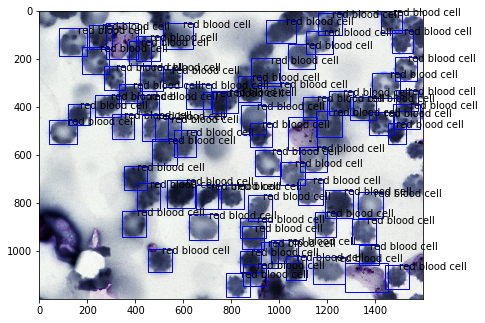

In [0]:
fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread('/content/drive/My Drive/rcnn/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png')
plt.imshow(image)


# iterating over the image for different objects
for _,row in test_df[test_df.image == "/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png"].iterrows():
    xmin = row.x_min
    #print(xmin)
    xmax = row.x_max
    ymin = row.y_min
    ymax = row.y_max
    
    width = xmax - xmin
    height = ymax - ymin
    # assign different color to different classes of objects
    if row.class_label == 'ring':
        edgecolor = 'r'
        ax.annotate('ring', xy=(xmax-40,ymin+20))
    elif row.class_label == 'red blood cell':
        edgecolor = 'b'
        ax.annotate('red blood cell', xy=(xmax-40,ymin+20))
        
    # add bounding boxes to the image
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

<h2> Modeling with Faster RCNN</h2>

* For training our dataset I have decided to use Faster RCNN

### How FasterRCNN works:

<h5>Faster-RCNN is composed of 3 neural networks — Feature Network, Region Proposal Network (RPN), Detection Network</h5>

<img src="faster RCNN.png">

<h4>Feature Network:</h4>
The Feature Network is usually a well known pre-trained image classification network such as VGG minus a few last/top layers. The function of this network is to generate good features from the images. The output of this network maintains the the shape and structure of the original image ( i.e. still rectangular, pixels in the original image roughly gets mapped to corresponding feature “pixels”, etc.)
<h4>Region Proposal Network (RPN):</h4>
The RPN is usually a simple network with a 3 convolutional layers. There is one common layer which feeds into a two layers — one for classification and the other for bounding box regression. The purpose of RPN is to generate a number of bounding boxes called Region of Interests ( ROIs) that has high probability of containing any object. The output from this network is a number of bounding boxes identified by the pixel co-ordinates of two diagonal corners, and a value (1, 0, or -1, indicating whether an object is in the bounding box or not or the box can be ignored respectively ).
<h4>Detection Network:</h4>
The Detection Network ( sometimes also called the RCNN network ) takes input from both the Feature Network and RPN , and generates the final class and bounding box. It is normally composed of 4 Fully Connected or Dense layers. There are 2 stacked common layers shared by a classification layer and a bounding box regression layer. To help it classify only the inside of the bounding boxes, the features are cropped according to the bounding boxes.

<img src="malaria.jpg">

* I have did necessary modification to  this repo <href>https://github.com/kbardool/keras-frcnn></href> and cloned here  

In [0]:
%cd /content

/content


In [0]:
!rm -rf drive

rm: cannot remove 'drive/My Drive/netflix/data_folder/test.csv': Operation not permitted
rm: cannot remove 'drive/My Drive/netflix/data_folder/data.csv': Operation not permitted
rm: cannot remove 'drive/My Drive/netflix/data_folder/combined_data_4.txt': Operation not permitted
rm: cannot remove 'drive/My Drive/netflix/data_folder/combined_data_3.txt': Operation not permitted
rm: cannot remove 'drive/My Drive/netflix/data_folder/combined_data_1.txt': Operation not permitted
rm: cannot remove 'drive/My Drive/netflix/data_folder/train.csv': Operation not permitted
rm: cannot remove 'drive/My Drive/netflix/data_folder/images/arrow.jpg': Operation not permitted
rm: cannot remove 'drive/My Drive/netflix/data_folder/images/data_c.jpg': Operation not permitted
rm: cannot remove 'drive/My Drive/netflix/data_folder/images/data_sparse_c.jpg': Operation not permitted
rm: cannot remove 'drive/My Drive/netflix/data_folder/images/models.jpg': Operation not permitted
rm: cannot remove 'drive/My Drive/

In [0]:
!git clone https://github.com/sandeepburra/keras-frcnn

Cloning into 'keras-frcnn'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 640 (delta 15), reused 0 (delta 0), pack-reused 611
Receiving objects: 100% (640/640), 194.05 KiB | 544.00 KiB/s, done.
Resolving deltas: 100% (431/431), done.


In [0]:
%cd keras-frcnn

/content/keras-frcnn


### Training Parameters:
##### parser details:
* -p : path for annotation file
* config_filename : path to create configuration file
* output_weight_path : path to create output weight file
* result_path : path to save training loss details in a csv format--> this is file allow as to resume training which is very important as we are running this on Google Colab
* number of Echos : 1000
##### Data Augumentation

* Horizontal Flip
* Vertical Flip
* rotation

* training logs are removed as they are very bigger

In [0]:
!python train_frcnn.py \
-o simple \
-p /content/drive/My\ Drive/rcnn/annotate_train.txt \
--config_filename /content/drive/My\ Drive/rcnn/Data_model/config.pickle \
--output_weight_path /content/drive/My\ Drive/rcnn/Data_model/model_frcnn.hdf5 \
--hf True \
--vf True \
--rot True \
--result_path /content/drive/My\ Drive/rcnn/Data_model/result_df.csv \
--num_epochs 1000

In [0]:
!python train_frcnn.py \
-o simple \
-p /content/drive/My\ Drive/rcnn/annotate_train.txt \
--config_filename /content/drive/My\ Drive/rcnn/Data_model/config.pickle \
--output_weight_path /content/drive/My\ Drive/rcnn/Data_model/model_frcnn.hdf5 \
--hf True \
--vf True \
--rot True \
--result_path /content/drive/My\ Drive/rcnn/Data_model/result_df.csv \
--input_weight_path /content/drive/My\ Drive/rcnn/Data_model/model_frcnn.hdf5 \
--num_epochs 1000

In [0]:
### Plotting all the losses During training

In [0]:
result = pd.read_csv("/content/drive/My Drive/rcnn/Data_model/result_df.csv")

In [0]:
result.shape

(1000, 7)

In [0]:
result.head()

,mean_overlapping_bboxes,class_acc,loss_rpn_cls,loss_rpn_regr,loss_class_cls,loss_class_regr,curr_loss
0,2.0,0.838,1.167,1.386,1.022,0.471,4.045
1,2.7,0.916,0.621,0.975,0.645,0.541,2.781
2,15.6,0.716,0.400,0.773,0.837,0.368,2.378
3,22.7,0.416,0.366,0.614,1.077,0.333,2.391
4,42.1,0.500,0.375,0.482,0.856,0.356,2.070


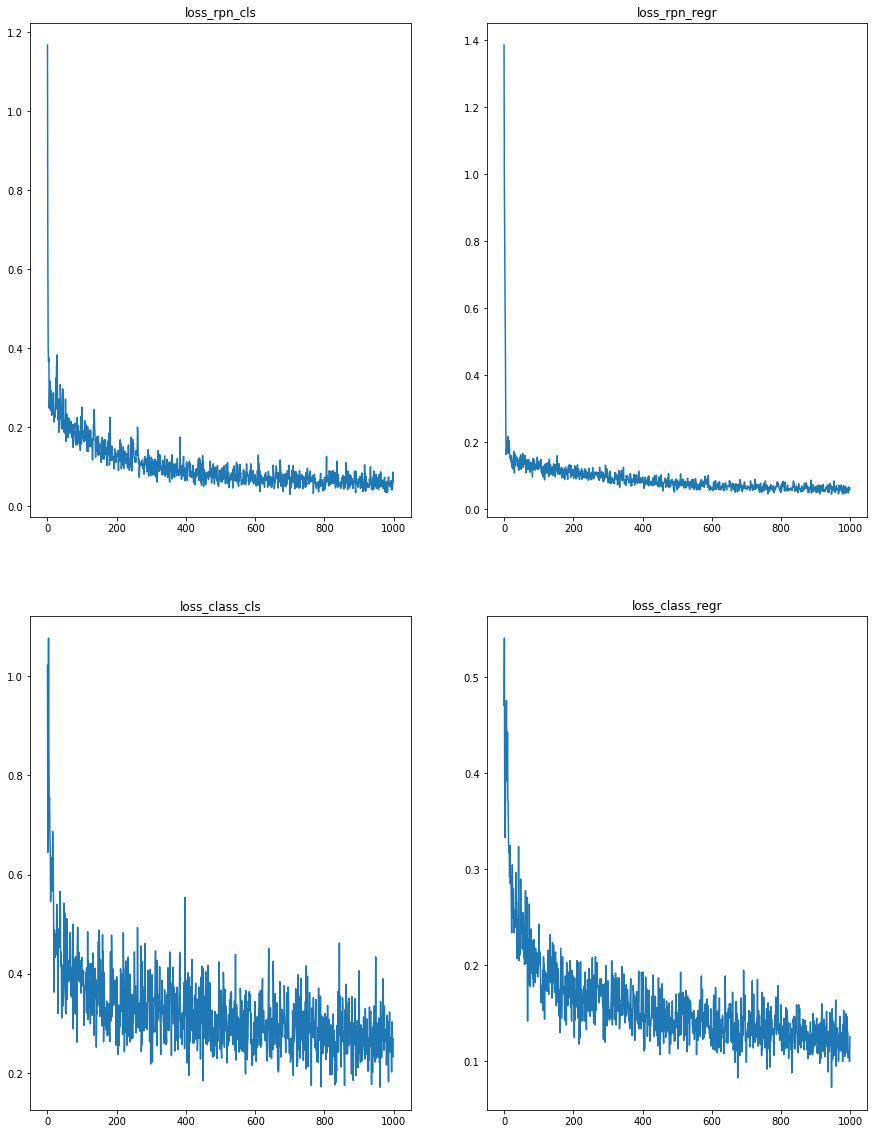

In [0]:
plt.figure(figsize=(15,20))
plt.subplot(2,2,1)
plt.plot(range(0, 1000), result['loss_rpn_cls'])
plt.title('loss_rpn_cls')
plt.subplot(2,2,2)
plt.plot(range(0, 1000), result['loss_rpn_regr'])
plt.title('loss_rpn_regr')

plt.subplot(2,2,3)
plt.plot(range(0, 1000), result['loss_class_cls'])
plt.title('loss_class_cls')
plt.subplot(2,2,4)
plt.plot(range(0, 1000), result['loss_class_regr'])
plt.title('loss_class_regr')

plt.show()

### Testing
* -p: path for test image
* --result_path_2class : path to create prediction csv fie
* config_filename: path to config file name which was created during training

In [0]:
!python test_frcnn.py \
-p /content/drive/My\ Drive/rcnn/testing \
--result_path_2class /content/drive/My\ Drive/rcnn/Data_model/prediction_df.csv \
--config_filename /content/drive/My\ Drive/rcnn/Data_model/config.pickle

Using TensorFlow backend.
{0: 'red blood cell', 1: 'schizont', 2: 'difficult', 3: 'ring', 4: 'leukocyte', 5: 'gametocyte', 6: 'trophozoite', 7: 'bg'}







Instructions for updating:
keep_dims is deprecated, use keepdims instead
Loading weights from /content/drive/My Drive/rcnn/Data_model/model_frcnn.hdf5



2019-11-15 06:01:54.478321: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-11-15 06:01:54.478567: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x9314540 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-11-15 06:01:54.478605: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2019-11-15 06:01:54.480713: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-11-15 06:01:54.549027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read fr

In [0]:
image = plt.imread('/content/drive/My Drive/rcnn/images/10be6380-cbbb-4886-8b9e-ff56b1710576.png')

In [0]:
image.shape

(1200, 1600, 3)

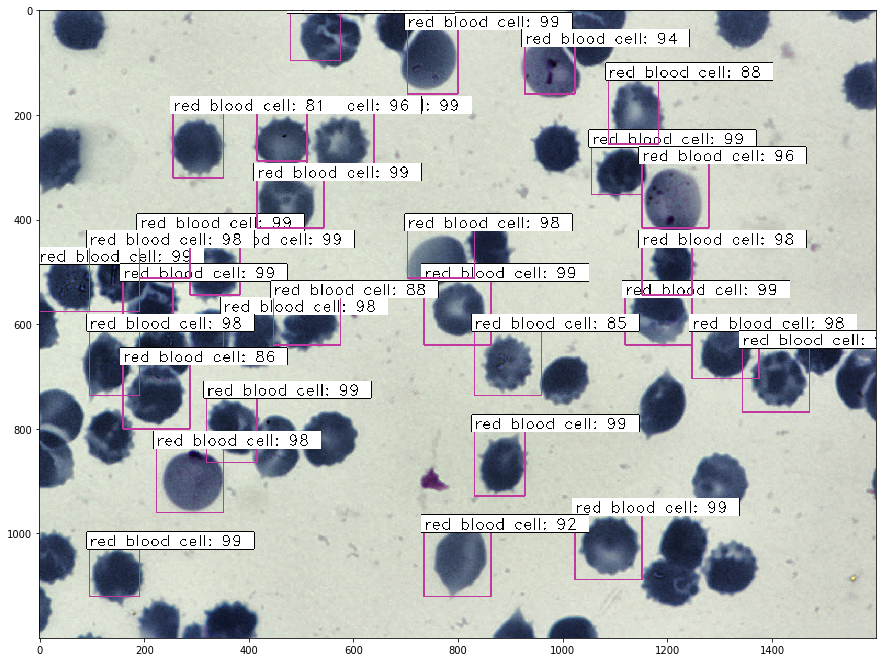

In [0]:
plt.figure(figsize=(15,20))
plt.imshow(image)

In [0]:
result_df_2class = pd.read_csv("/content/drive/My Drive/rcnn/Data_model_2/result_df_2class.csv")

In [0]:
result_df_2class["label"].value_counts()

RBC    65
Name: label, dtype: int64

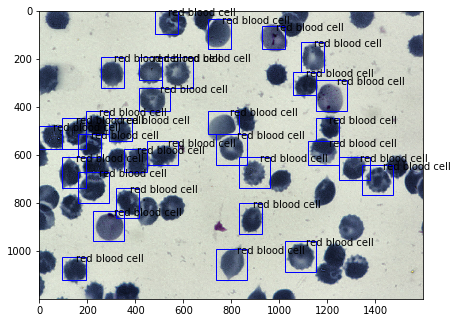

In [0]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread('/content/drive/My Drive/rcnn/testing/a9feccda-18f2-405e-9aa1-409fa1f49fe4.png')
plt.imshow(image)


# iterating over the image for different objects
for _,row in result_df_2class.iterrows():
    xmin = row.x1
    #print(xmin)
    xmax = row.x2
    ymin = row.y1
    ymax = row.y2
    
    width = xmax - xmin
    height = ymax - ymin
    # assign different color to different classes of objects
    if row.label == 'ring':
        edgecolor = 'r'
        ax.annotate('ring', xy=(xmax-40,ymin+20))
    elif row.label == 'red blood cell':
        edgecolor = 'b'
        ax.annotate('red blood cell', xy=(xmax-40,ymin+20))
        
    # add bounding boxes to the image
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

### Observations:
* As the datset is highly imbalanced, Red Blood cells will dominate over other classes.
* We cannot predict minor classes like leukocyte(count:85) against Major class Red Blood Cell(count:62875)
* So to make our model efficient we will devide our problem into two models

### Procedure:

### Model 1:
* First we will create dataset with two lables, RBC and other(all classes together except RBC)
* FRCNN model will be trined on this data, and will predict Bounding boxes and two class labels RBC and other

### Model 2:
* we will crop the images with the bounding box dimensions other class(Except RBC).
* Train a densenet model on this cropped image,for all other classes.
* while testing we will take output of model 1 and feed to model 2

### Data for first classifier(Object detection with Bounding Boxes)

In [0]:
import pandas as pd

In [0]:
train_df = pd.read_csv("/content/drive/My Drive/rcnn/train_df.csv")
test_df = pd.read_csv("/content/drive/My Drive/rcnn/test_df.csv")

In [0]:
train_df['class_label'].value_counts()

red blood cell    62875
trophozoite        1207
difficult           335
ring                281
schizont            142
gametocyte          113
leukocyte            85
Name: class_label, dtype: int64

In [0]:
train_df_final = train_df.copy()

In [0]:
train_df_final.head()

,index,image,y_max,y_min,x_max,x_min,class_label,avialability
0,0,/images/10be6380-cbbb-4886-8b9e-ff56b1710576.png,832,734,834,735,red blood cell,True
1,1,/images/10be6380-cbbb-4886-8b9e-ff56b1710576.png,1039,939,1378,1283,red blood cell,True
2,2,/images/10be6380-cbbb-4886-8b9e-ff56b1710576.png,476,367,1235,1134,red blood cell,True
3,3,/images/10be6380-cbbb-4886-8b9e-ff56b1710576.png,400,307,864,766,red blood cell,True
4,4,/images/10be6380-cbbb-4886-8b9e-ff56b1710576.png,701,596,1556,1463,red blood cell,True


In [0]:
train_df_final['class_label'].value_counts()

red blood cell    62875
trophozoite        1207
difficult           335
ring                281
schizont            142
gametocyte          113
leukocyte            85
Name: class_label, dtype: int64

In [0]:
train_df_final['class_label'].unique()

array(['red blood cell', 'schizont', 'difficult', 'ring', 'leukocyte',
       'gametocyte', 'trophozoite'], dtype=object)

In [0]:
train_df_final["2class"] = train_df_final['class_label'].replace(['schizont', 'difficult', 'ring', 'leukocyte','gametocyte', 'trophozoite'],"other")

In [0]:
train_df_final.head()

,index,image,y_max,y_min,x_max,x_min,class_label,avialability,2class
0,0,/images/10be6380-cbbb-4886-8b9e-ff56b1710576.png,832,734,834,735,red blood cell,True,red blood cell
1,1,/images/10be6380-cbbb-4886-8b9e-ff56b1710576.png,1039,939,1378,1283,red blood cell,True,red blood cell
2,2,/images/10be6380-cbbb-4886-8b9e-ff56b1710576.png,476,367,1235,1134,red blood cell,True,red blood cell
3,3,/images/10be6380-cbbb-4886-8b9e-ff56b1710576.png,400,307,864,766,red blood cell,True,red blood cell
4,4,/images/10be6380-cbbb-4886-8b9e-ff56b1710576.png,701,596,1556,1463,red blood cell,True,red blood cell


In [0]:
train_df_final['class_label'].replace("red blood cell", "RBC", inplace= True)


In [0]:
train_df_final['2class'].replace("red blood cell", "RBC", inplace= True)

In [0]:
data = pd.DataFrame()
data['format'] = train_df_final['image']
print(data.shape)
for i in range(data.shape[0]):
    data['format'][i] = '/content/drive/My Drive/rcnn' + data['format'][i]

f= open(f"/content/drive/My Drive/rcnn/annotate_train_2class.txt","w+")
for i in range(data.shape[0]):
    data['format'][i] = data['format'][i] + ',' + str(train_df_final['x_min'][i]) + ',' + str(train_df_final['y_min'][i]) + ',' + str(train_df_final['x_max'][i]) + ',' + str(train_df_final['y_max'][i])+ ',' + train_df_final['2class'][i]
    f.write(data['format'][i])
    f.write("\n")
f.close()


(65038, 1)


In [0]:
test_df_final = test_df.copy()
test_df_final["2class"] = test_df_final['class_label'].replace(['schizont', 'difficult', 'ring', 'leukocyte','gametocyte', 'trophozoite'],"other")
test_df_final['class_label'].replace("red blood cell", "RBC", inplace= True)
test_df_final['2class'].replace("red blood cell", "RBC", inplace= True)

In [0]:
test_df_final.reset_index(inplace=True)

In [0]:
data = pd.DataFrame()
data['format'] = test_df_final['image']
for i in range(data.shape[0]):
    data['format'][i] = '/content/drive/My Drive/rcnn' + data['format'][i]

f= open(f"/content/drive/My Drive/rcnn/annotate_test_2class.txt","w+")
for i in range(data.shape[0]):
    data['format'][i] = data['format'][i] + ',' + str(test_df_final['x_min'][i]) + ',' + str(test_df_final['y_min'][i]) + ',' + str(test_df_final['x_max'][i]) + ',' + str(test_df_final['y_max'][i])+ ',' + test_df_final['2class'][i]
    f.write(data['format'][i])
    f.write("\n")
f.close()

### Data for Second classifier

In [0]:
other =train_df_final[train_df_final['2class']=="other"]

In [0]:
other.reset_index(inplace = True)

In [0]:
other.head()

,level_0,index,image,y_max,y_min,x_max,x_min,class_label,avialability,2class
0,78,78,/images/6b14c855-8561-417c-97a4-63fa552842fd.png,219,76,626,482,schizont,True,other
1,79,79,/images/6b14c855-8561-417c-97a4-63fa552842fd.png,1143,1020,1314,1156,difficult,True,other
2,82,82,/images/13099edb-35d9-438f-b093-2cf2ebf9d255.png,337,208,446,324,ring,True,other
3,125,125,/images/2559636b-f01a-4414-93da-210c3b12d153.png,803,661,558,422,difficult,True,other
4,138,138,/images/2559636b-f01a-4414-93da-210c3b12d153.png,324,169,717,576,difficult,True,other


In [0]:
y = other["class_label"]

In [0]:
np.savez("/content/drive/My Drive/rcnn/train_image_array/y_target", y)

In [0]:
y_train = np.load("/content/drive/My Drive/rcnn/train_image_array/y_target.npz")

In [0]:
y_train["arr_0"].shape

(2163,)

In [0]:
import cv2
x = [] 
y = []
WIDTH = 64
HEIGHT = 64

for i in tqdm(range(other.shape[0])):
  image = plt.imread('/content/drive/My Drive/rcnn/' + other["image"][i])
  image_crop = image[other["y_min"][i]:other["y_max"][i],other["x_min"][i]:other["x_max"][i]]
  x.append(cv2.resize(image_crop, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))



100%|██████████| 2163/2163 [05:49<00:00,  6.46it/s]


In [0]:
np.savez("/content/drive/My Drive/rcnn/train_image_array/x_train_images_arrays_64pix", x)

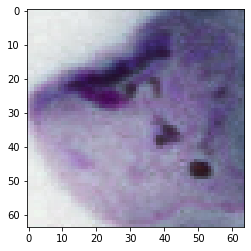

In [0]:
from matplotlib import pyplot as plt
plt.imshow(x_test["arr_0"][1], interpolation='nearest')
plt.show()

In [0]:
other_test =test_df_final[test_df_final['2class']=="other"]

In [0]:
other_test.reset_index(inplace = True)

In [0]:
other_test.head()

,level_0,index,image,y_max,y_min,x_max,x_min,class_label,avialability,2class
0,54,54,/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,200,52,409,279,trophozoite,True,other
1,61,61,/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,578,441,1155,1037,trophozoite,True,other
2,62,62,/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,1172,1050,1454,1273,trophozoite,True,other
3,92,92,/images/0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png,317,194,356,237,trophozoite,True,other
4,94,94,/images/0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png,713,578,178,53,trophozoite,True,other


In [0]:
y_test = other_test["class_label"]

In [0]:
np.savez("/content/drive/My Drive/rcnn/test_image_array/y_target_test", y_test)

In [0]:
import cv2
x = [] 
y = []
WIDTH = 64
HEIGHT = 64

for i in tqdm(range(other_test.shape[0])):
  image = plt.imread('/content/drive/My Drive/rcnn/' + other_test["image"][i])
  image_crop = image[other_test["y_min"][i]:other_test["y_max"][i],other_test["x_min"][i]:other_test["x_max"][i]]
  x.append(cv2.resize(image_crop, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))



100%|██████████| 527/527 [03:26<00:00,  2.49it/s]


In [0]:
np.savez("/content/drive/My Drive/rcnn/test_image_array/x_images_arrays_test_64pix", x)

In [0]:
x_test = np.load("/content/drive/My Drive/rcnn/test_image_array/x_images_arrays_test_64pix.npz")

### First level Classifer Training

###### Using weights from the model trained before

In [0]:
!python train_frcnn.py \
-o simple \
-p /content/drive/My\ Drive/rcnn/annotate_train_2class.txt \
--config_filename /content/drive/My\ Drive/rcnn/Data_model_2/config.pickle \
--output_weight_path /content/drive/My\ Drive/rcnn/Data_model_2/model_frcnn.hdf5 \
--hf True \
--vf True \
--rot True \
--result_path /content/drive/My\ Drive/rcnn/Data_model/result_df.csv \
--input_weight_path /content/drive/My\ Drive/rcnn/Data_model/model_frcnn.hdf5 \
--num_epochs 1000

Using TensorFlow backend.
Parsing annotation files
959
Training images per class:
{'RBC': 62875, 'bg': 0, 'other': 2163}
Num classes (including bg) = 3
Config has been written to /content/drive/My Drive/rcnn/Data_model_2/config.pickle, and can be loaded when testing to ensure correct results
Num train samples 795
Num val samples 164







Instructions for updating:
keep_dims is deprecated, use keepdims instead
loading weights from /content/drive/My Drive/rcnn/Data_model/model_frcnn.hdf5



2019-11-26 01:49:27.615781: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2019-11-26 01:49:27.616050: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x817c540 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-11-26 01:49:27.616085: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2019-11-26 01:49:27.618335: I tensorflow/stream_executor/platform/defaul

In [0]:
!python train_frcnn.py \
-o simple \
-p /content/drive/My\ Drive/rcnn/annotate_train_2class.txt \
--config_filename /content/drive/My\ Drive/rcnn/Data_model_2/config.pickle \
--output_weight_path /content/drive/My\ Drive/rcnn/Data_model_2/model_frcnn.hdf5 \
--hf True \
--vf True \
--rot True \
--is_it_resume = True \
--result_path /content/drive/My\ Drive/rcnn/Data_model/result_df.csv \
--input_weight_path /content/drive/My\ Drive/rcnn/Data_model_2/model_frcnn.hdf5 \
--num_epochs 1000

Using TensorFlow backend.
Parsing annotation files
959
Training images per class:
{'RBC': 62875, 'bg': 0, 'other': 2163}
Num classes (including bg) = 3
Config has been written to /content/drive/My Drive/rcnn/Data_model_2/config.pickle, and can be loaded when testing to ensure correct results
Num train samples 824
Num val samples 135







Instructions for updating:
keep_dims is deprecated, use keepdims instead
Continue training based on previous trained model
Loading weights from /content/drive/My Drive/rcnn/Data_model_2/model_frcnn.hdf5



2019-11-26 15:46:17.408237: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2019-11-26 15:46:17.410526: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x8f5e540 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-11-26 15:46:17.410559: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2019-11-26 15:46:17.

In [0]:
result = pd.read_csv("/content/drive/My Drive/rcnn/Data_model/result_df.csv")

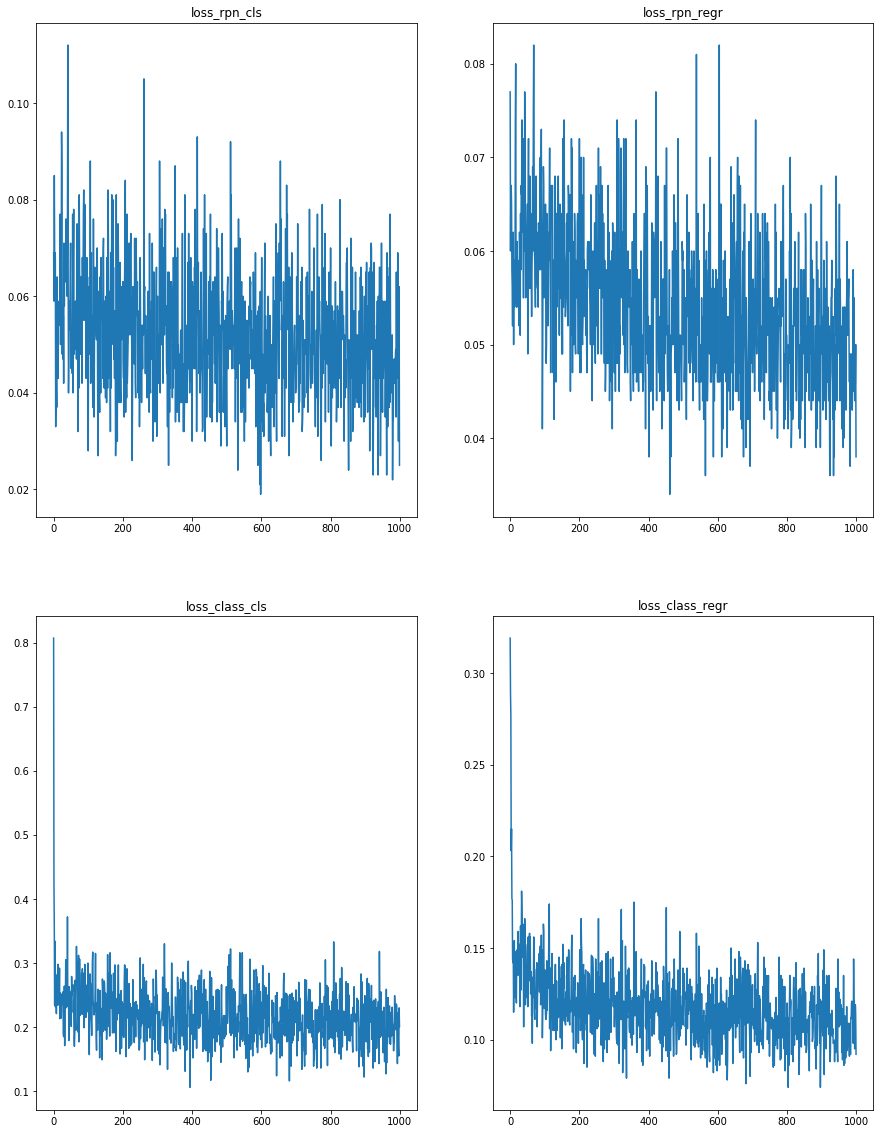

In [0]:
plt.figure(figsize=(15,20))
plt.subplot(2,2,1)
plt.plot(range(0, 1000), result['loss_rpn_cls'])
plt.title('loss_rpn_cls')
plt.subplot(2,2,2)
plt.plot(range(0, 1000), result['loss_rpn_regr'])
plt.title('loss_rpn_regr')

plt.subplot(2,2,3)
plt.plot(range(0, 1000), result['loss_class_cls'])
plt.title('loss_class_cls')
plt.subplot(2,2,4)
plt.plot(range(0, 1000), result['loss_class_regr'])
plt.title('loss_class_regr')

plt.show()

### 2nd level classifier training

In [0]:
##### for training I am using densenet structure

In [0]:
X_train = np.load("/content/drive/My Drive/rcnn/train_image_array/x_train_images_arrays.npz", allow_pickle = True)
X_test = np.load("/content/drive/My Drive/rcnn/test_image_array/x_images_arrays_test.npz", allow_pickle = True)

In [0]:
y_train = np.load("y_target.npz", allow_pickle = True)
y_test = np.load("y_target_test.npz", allow_pickle = True)

In [0]:
print("Train dataset shape",X_train["arr_0"].shape)
print("Test dataset shape",X_test["arr_0"].shape)

Train dataset shape (2163, 32, 32, 3)
Test dataset shape (527, 32, 32, 3)


In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
# from tensorflow import keras

# from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
# import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.75
config.gpu_options.allow_growth= True
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

# Create a session with the above options specified.
# k.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
type(y_train["arr_0"])

numpy.ndarray

In [0]:
unique, counts = np.unique(y_train["arr_0"], return_counts=True)

In [0]:
dict(zip(unique, counts))

{'difficult': 335,
 'gametocyte': 113,
 'leukocyte': 85,
 'ring': 281,
 'schizont': 142,
 'trophozoite': 1207}

In [0]:
unique

array(['difficult', 'gametocyte', 'leukocyte', 'ring', 'schizont',
       'trophozoite'], dtype=object)

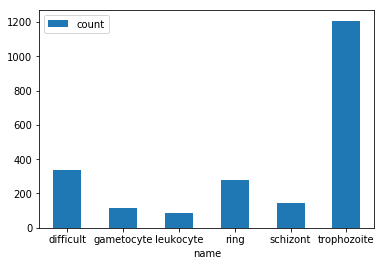

In [0]:
df = pd.DataFrame({"name":unique,"count" :counts})
ax = df.plot.bar(x='name', y='count', rot=0)

In [0]:
unique, counts = np.unique(y_test["arr_0"], return_counts=True)

In [0]:
dict(zip(unique, counts))

{'difficult': 104,
 'gametocyte': 31,
 'leukocyte': 18,
 'ring': 72,
 'schizont': 37,
 'trophozoite': 265}

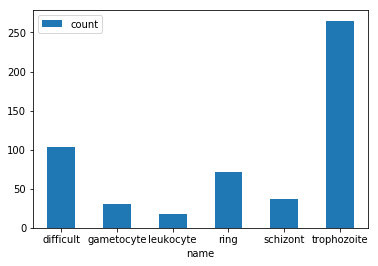

In [0]:
df = pd.DataFrame({"name":unique,"count" :counts})
ax = df.plot.bar(x='name', y='count', rot=0)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
vect = CountVectorizer()
y_train_vect = vect.fit_transform(y_train["arr_0"])

In [0]:
y_test_vect = vect.transform(y_test["arr_0"])

In [0]:
vect.get_feature_names()

['difficult', 'gametocyte', 'leukocyte', 'ring', 'schizont', 'trophozoite']

In [0]:
y_test_vect.toarray()

array([[0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

In [0]:
print("Train dataset shape:",X_train["arr_0"].shape,y_train_vect.shape)
print("Test dataset shape",X_test["arr_0"].shape,y_test_vect.shape)

Train dataset shape: (2163, 32, 32, 3) (2163, 6)
Test dataset shape (527, 32, 32, 3) (527, 6)


In [0]:
img_height, img_width, channel = X_train["arr_0"].shape[1],X_train["arr_0"].shape[2],X_train["arr_0"].shape[3]


In [0]:
X_train_mean = np.mean(X_train["arr_0"], axis=(0,1,2))
X_train_std = np.std(X_train["arr_0"], axis=(0,1,2))
X_train = (X_train["arr_0"] - X_train_mean) / X_train_std
X_test = (X_test["arr_0"] - X_train_mean) / X_train_std

In [0]:
X_test.shape

(527, 32, 32, 3)

In [0]:
batch_size = 32
num_classes = 6
epochs = 100
l = 50
compression = 0.45
dropout_rate = 0.2

In [0]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.5):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.SeparableConv2D(int(num_filter*compression), (5,5), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.5):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.SeparableConv2D(int(num_filter*compression), (7,7), use_bias=False,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [0]:
import keras.backend as K
K.clear_session()


In [0]:
num_filter = 64

dropout_rate = 0
l = 10

input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.SeparableConv2D(num_filter, (5,5), use_bias=False, padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 32, 32, 64)   267         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         separable_conv2d[0][0]           
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range = 0.1
    )
datagen.fit(X_train)

In [0]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau, LearningRateScheduler

In [0]:
import math

In [0]:
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath="epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint_1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, mode='max')


In [0]:

reduce_lr_1 = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=4,verbose = 1)

In [0]:
earlystopping_1 = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [0]:
callbacks_list = [earlystopping_1,reduce_lr_1,checkpoint_1]

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [0]:
y_train = y_train_vect.toarray()
y_test = y_test_vect.toarray()

In [0]:
y_test.shape

(527, 6)

In [0]:
result = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=X_train.shape[0] // 16,
                    epochs=100,
                    verbose=1, 
                    validation_data=(X_test, y_test),callbacks=callbacks_list)

Epoch 1/100
134/135 [============================>.] - ETA: 0s - loss: 1.0972 - acc: 0.6049
Epoch 00001: saving model to epochs:001-val_acc:0.503.hdf5
135/135 [==============================] - 38s 281ms/step - loss: 1.0953 - acc: 0.6050 - val_loss: 1.5779 - val_acc: 0.5028
Epoch 2/100
134/135 [============================>.] - ETA: 0s - loss: 0.9198 - acc: 0.6464
Epoch 00002: saving model to epochs:002-val_acc:0.503.hdf5
135/135 [==============================] - 12s 92ms/step - loss: 0.9193 - acc: 0.6463 - val_loss: 1.3714 - val_acc: 0.5028
Epoch 3/100
134/135 [============================>.] - ETA: 0s - loss: 0.8712 - acc: 0.6618
Epoch 00003: saving model to epochs:003-val_acc:0.548.hdf5
135/135 [==============================] - 12s 92ms/step - loss: 0.8685 - acc: 0.6631 - val_loss: 1.1550 - val_acc: 0.5484
Epoch 4/100
134/135 [============================>.] - ETA: 0s - loss: 0.8249 - acc: 0.6818
Epoch 00004: saving model to epochs:004-val_acc:0.605.hdf5
135/135 [=================

In [0]:
def plt_dynamic_auc(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation auc")
    ax.plot(x, ty, 'r', label="Train auc")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

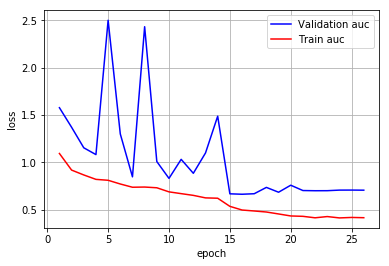

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('loss')

# list of epoch numbers
x = list(range(1,26+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = result.history['val_loss']
ty = result.history['loss']
plt_dynamic_auc(x, vy, ty, ax)

### Testing

In [ ]:
!python test_frcnn.py \
-p /content/drive/My\ Drive/rcnn/train_images \
--result_path_2class /content/drive/My\ Drive/rcnn/Data_model_2/result_df_2class_train.csv \
--config_filename /content/drive/My\ Drive/rcnn/Data_model_2/config.pickle

In [ ]:
!python test_frcnn.py \
-p /content/drive/My\ Drive/rcnn/test_images \
--result_path_2class /content/drive/My\ Drive/rcnn/Data_model_2/result_df_2class.csv \
--config_filename /content/drive/My\ Drive/rcnn/Data_model_2/config.pickle

In [0]:
def get_map(annotate_path, result_df_path):

	def get_data(input_path):

		img_data = []
		
		with open(input_path,'r') as f:
			for line in f:
				line_split = line.strip().split(',')
				(filename,x1,y1,x2,y2,class_name) = line_split	

				img_data.append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})
			
		return img_data
	def union(au, bu, area_intersection):
		area_a = (au[2] - au[0]) * (au[3] - au[1])
		area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
		area_union = area_a + area_b - area_intersection
		return area_union


	def intersection(ai, bi):
		x = max(ai[0], bi[0])
		y = max(ai[1], bi[1])
		w = min(ai[2], bi[2]) - x
		h = min(ai[3], bi[3]) - y
		if w < 0 or h < 0:
			return 0
		return w*h

	def iou(a, b):
		# a and b should be (x1,y1,x2,y2)

		if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
			return 0.0

		area_i = intersection(a, b)
		area_u = union(a, b, area_i)

		return float(area_i) / float(area_u + 1e-6)
	gt = get_data(annotate_path)
	pred = pd.read_csv(result_df_path)
	pred.columns = ["name", "class", "x1","y1","x2","y2", "prob"]
	Truth = {}
	Predicted = {}


	for bbox in gt:
		bbox['bbox_matched'] = False

	pred_probs = np.array(pred["prob"])
	box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]

	for box_idx in tqdm(box_idx_sorted_by_prob):
		pred_box = pred.loc[box_idx]
		pred_class = pred_box['class']
		pred_x1 = pred_box['x1']
		pred_x2 = pred_box['x2']
		pred_y1 = pred_box['y1']
		pred_y2 = pred_box['y2']
		pred_prob = pred_box['prob']
		if pred_class not in Predicted:
			Predicted[pred_class] = []
			Truth[pred_class] = []
		Predicted[pred_class].append(pred_prob)
		found_match = False
		for gt_box in gt:
			gt_class = gt_box['class']
			gt_x1 = gt_box['x1']
			gt_x2 = gt_box['x2']
			gt_y1 = gt_box['y1']
			gt_y2 = gt_box['y2']
			gt_seen = gt_box['bbox_matched']
			if gt_class != pred_class:
				continue
			if gt_seen:
				continue
			iou1 = iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
			if iou1 >= 0.5:
				found_match = True
				gt_box['bbox_matched'] = True
				break
			else:
				continue
		

		Truth[pred_class].append(int(found_match))

	for gt_box in gt:
		if not gt_box['bbox_matched']:
			if gt_box['class'] not in Predicted:
				Predicted[gt_box['class']] = []
				Truth[gt_box['class']] = []

			Truth[gt_box['class']].append(1)
			Predicted[gt_box['class']].append(0)
	t = {}
	p = {}
	for key in Truth.keys():
			if key not in t:
				t[key] = []
				p[key] = []
			t[key].extend(Truth[key])
			p[key].extend(Predicted[key])
	all_aps = []
	for key in t.keys():
		ap = average_precision_score(t[key], p[key])
		print('{} AP: {}'.format(key, ap))
		all_aps.append(ap)
	print('mAP = {}'.format(np.mean(np.array(all_aps))))
	

In [0]:
print("train map:")
get_map("/content/drive/My Drive/rcnn/annotate_train_2class.txt","/content/drive/My Drive/rcnn/Data_model_2/result_df_2class_train.csv" )


train map:


100%|██████████| 40765/40765 [12:16<00:00, 33.65it/s]


RBC AP: 0.999631335703299
other AP: 0.9872680356204361
mAP = 0.9934496856618675
